In [1]:
from torch.utils.data import DataLoader
import torch
from tqdm.notebook import tqdm
import numpy as np
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import shutil
import torch.nn.functional as F
import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
def OA(pre_classes, gt_classes):
    return torch.sum(torch.tensor(pre_classes) == torch.tensor(gt_classes)).float()/len(pre_classes)

In [3]:
pretrained_size = 256
pretrained_means = [0.3980, 0.4097, 0.3696]
pretrained_stds= [0.1468, 0.1340, 0.1303]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [15]:
Log_path = 'ex_UCM/'
num_class = 21
train_dir = '/home/amax/yyq/Graph_convolution_self/Datasets/UCMerced_LandUse/0.8/train'
test_dir = '/home/amax/yyq/Graph_convolution_self/Datasets/UCMerced_LandUse/0.8/test/'


# Log_path = 'ex_AID/'
# num_class = 30
# train_dir = '/home/amax/yyq/Graph_convolution_self/Datasets/AID/28/train/'
# test_dir = '/home/amax/yyq/Graph_convolution_self/Datasets/AID/28/test/'

if not os.path.exists(Log_path):
    os.mkdir(Log_path)

train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

batch_size = 32
tra_Dataloader = DataLoader(train_data, batch_size, shuffle=True,
                                               num_workers=8, pin_memory=True)
tes_Dataloader = DataLoader(test_data, batch_size*4, shuffle=False,
                                               num_workers=8, pin_memory=True)

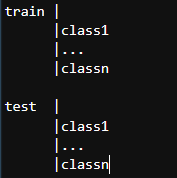

In [5]:
from Tools.Dfpn import dfpn
from Tools.GCNK import Graph2dConvolution

In [6]:
class GCN(nn.Module):
    def __init__(self, nfeat, ofeat,block_num):
        super(GCN, self).__init__()
        self.convindex = nn.Conv2d(nfeat, block_num, 5,padding=2)
        
        self.gc= Graph2dConvolution(nfeat,ofeat,kernel_size = 3, block_num = block_num, padding=1)
        self.bn= nn.BatchNorm2d(ofeat)

    def forward(self, x):
        index_f = self.convindex(x)
        value, index = torch.max(index_f, dim=1, keepdim=True)
        x = self.gc(x,index)
        x = self.bn(x)
        return x
    
class GraphClassification(nn.Module):
    def __init__(self, block_num, labelnum, channel_num):
        super(GraphClassification, self).__init__()
        self.dpfn = dfpn(trans_channel_num = channel_num, resnet_type=resnet_type)
        self.gcn = GCN(channel_num, labelnum, block_num = block_num)
        
    def forward(self, img):
        features = self.dpfn(img)
        features = self.gcn(features)
        final_class = torch.mean(features,dim=(2,3))
        return final_class

In [7]:
EPOCHS = 1000
FOUND_LR = 4e-5

block = 8
tras_ch = 128
resnet_type='resnet34'

In [9]:
model = GraphClassification(block,num_class,tras_ch).cuda()
lossf = nn.CrossEntropyLoss()

opt = torch.optim.Adam(model.parameters(), lr = FOUND_LR)

STEPS_PER_EPOCH = len(tra_Dataloader)
TOTAL_STEPS = STEPS_PER_EPOCH * (EPOCHS//5)
scheduler = lr_scheduler.StepLR(opt, step_size=TOTAL_STEPS, gamma=0.1)

In [ ]:
best_acc_test = 0
for epoch in range(EPOCHS):
    '''train'''
    model.train()
    losses = []
    for i,(img,label) in enumerate(tqdm(tra_Dataloader)):
        opt.zero_grad()
        img,label = img.cuda(),label.cuda()
        pred_cls = model(img)
        
        loss_class = lossf(pred_cls,label)
        loss = loss_class
        loss.backward()
        opt.step()
        scheduler.step()
        
        losses.append(float(loss.detach()))
        if i%20 == 0:
            print(np.mean(losses))
        
    '''test'''
    with torch.no_grad():
        model.eval()
        pre_classes = []
        gt_classes = []
        for i,(img,label) in enumerate(tqdm(tes_Dataloader)):
            img,label = img.cuda(),label.cuda()
            pre_class = model(img)

            pre_classes = pre_classes + list(np.array(torch.argmax(pre_class,dim=1).detach().cpu()))
            gt_classes = gt_classes + list(np.array(label.cpu()))

        mean_acc = OA(pre_classes, gt_classes)
        mean_acc = round(float(mean_acc),4)
        print('epoch:',epoch,'test_precison:',mean_acc,'best_test:',best_acc_test)
        f = open(Log_path+'log.txt','a')
        f.write('Epoch:'+str(epoch)+'   acc:'+str(mean_acc)+'   Bestacc:'+str(best_acc_test)+'\n')
        f.close()

        if best_acc_test < mean_acc:
            best_acc_test = mean_acc
            torch.save(model.state_dict(), Log_path+'best.pth')

In [11]:
tess_Dataloader = DataLoader(test_data, 128, shuffle=True,
                                               num_workers=8, pin_memory=True)
model = GraphClassification(block,num_class,tras_ch).cuda()
model.load_state_dict(torch.load(Log_path+'best.pth'))
with torch.no_grad():
    model.eval()
    pre_classes = []
    gt_classes = []
    outputs = []
    for i,(img,label) in enumerate(tqdm(tess_Dataloader)):
        img,label = img.cuda(),label.cuda()
        pre_class =  model(img)
    #     break
        outputs = outputs + list(pre_class.detach())
        pre_classes = pre_classes + list(np.array(torch.argmax(pre_class,dim=1).detach().cpu()))
        gt_classes = gt_classes + list(np.array(label.cpu()))

    # mean_acc = OA(pre_classes, gt_classes)
    # mean_acc = round(float(mean_acc),4)
    # print(mean_acc)

    from Tools.performance import performance
    OA,AA,KAAPA, Percision_list = performance(torch.tensor(pre_classes), torch.tensor(gt_classes),num_class)
    print('OA:',round(OA,4),'AA:',round(AA,4),'KAPPA:',round(KAAPA,4),'\n', Percision_list)

  0%|          | 0/4 [00:00<?, ?it/s]

OA: 1.0 AA: 1.0 KAPPA: 1.0 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


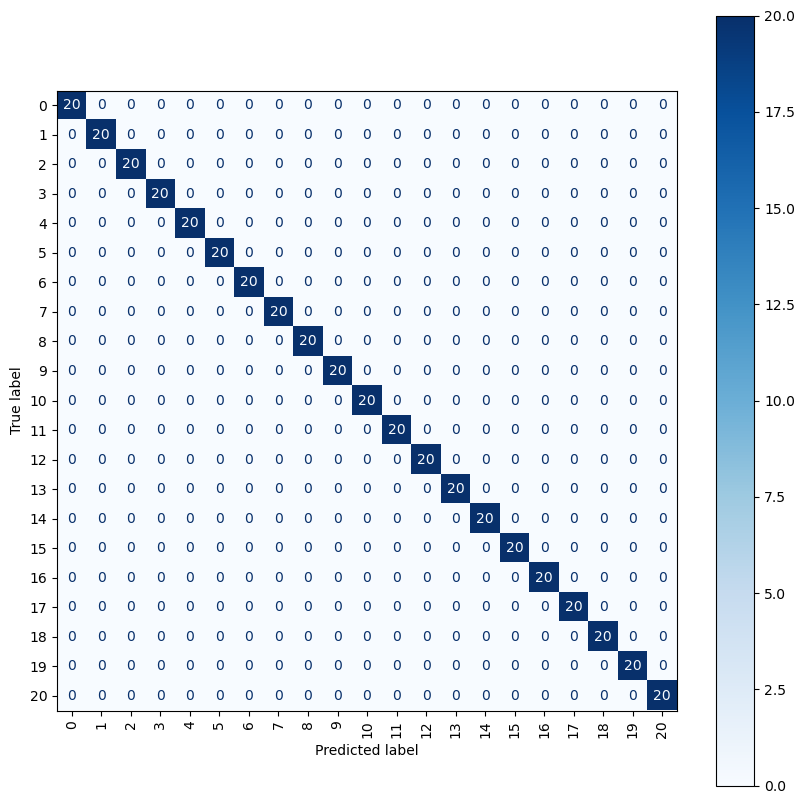

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(dpi=100,figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 90)
    
plot_confusion_matrix(gt_classes, pre_classes, range(num_class))